# Trajectory Recommendation

<a id='toc'></a>

[Table of Contents](#toc)
1. [Preprocess Dataset](#sec1)
  1. [Load Data](#sec1.1)
  1. [Compute POI Information](#sec1.2)
  1. [Construct Travelling Sequences](#sec1.3)
  1. [Train vs. Test Data](#sec1.4)

1. [User Agnostic POI Ranking](#sec2)
  1. [POI Features for Ranking](#sec2.1)
  1. [Training DataFrame](#sec2.2)
  1. [Test DataFrame](#sec2.3)
  1. [Platt Scaling](#sec2.4)
  1. [Ranking POIs using rankSVM](#sec2.5)

1. [Factorise Transition Probabilities in POI Feature Space](#sec3)
  1. [POI Features for Factorisation](#sec3.1)
  1. [Transition Matrix between POI Cateogries](#sec3.2)
  1. [Transition Matrix between POI Popularity Classes](#sec3.3)
  1. [Transition Matrix between POI Average Visit Duration Classes](#sec3.4)
  1. [Transition Matrix between POI Neighborhood Classes](#sec3.5)
  1. [Transition Matrix between POI Features](#sec3.6)

1. [Combine Ranking with Factorised Markov Chain to Recommend](#sec4)
1. [Evaluation](#sec5)

<a id='sec1'></a>

# 1. Preprocess Dataset

In [118]:
% matplotlib inline

import os, re, sys, time, pickle, tempfile
import math, random, itertools, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from scipy.linalg import kron
from scipy.misc import logsumexp
from joblib import Parallel, delayed
from numba import jit
from sklearn.cluster import KMeans

In [119]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [120]:
def print_progress(cnt, total):
    """
    Display a progress bar.
    """
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

In [121]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [122]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-combine-' + suffix + '.pkl')
#fF1data = os.path.join(data_dir, 'F1-combine-' + suffix + '.pkl')
#fmlikeseq = os.path.join(data_dir, 'mlike-seq-' + suffix + '.pkl')

<a id='sec1.1'></a>

## 1.1 Load Data

In [123]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [124]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


<a id='sec1.2'></a>

## 1.2 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [125]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [126]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [127]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


<a id='sec1.3'></a>

## 1.3 Construct Travelling Sequences

In [128]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


**Filtering out** a visit of POI with $0$ duration, i.e. only one photo was taken.

In [129]:
seq_all = seq_all[seq_all['#photo'] > 1]

In [130]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,userID,seqLen
seqID,,
2,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1
6,10014440@N06,1
7,10014440@N06,1


In [131]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [132]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    return poi_info.copy()

<a id='sec1.4'></a>

## 1.4 Train vs. Test Data

Remove duplicate trajectories, i.e. same trajectory for different users.

In [133]:
seq_stats = seq_stats[seq_stats['seqLen'] > 2]
seq_stats = seq_stats[seq_stats['seqLen'] < 10]
seqid_set_ = seq_stats.index.tolist()
seq_dict = dict()
for seqid in seqid_set_:
    seq = extract_seq(seqid, seq_all)
    key = str(seq)
    if key in seq_dict: seq_dict[key].append(seqid)
    else: seq_dict[key] = [seqid]

In [134]:
len(seqid_set_)

120

In [135]:
seqid_set_exp = [seq_dict[x][0] for x in sorted(seq_dict.keys())]

In [136]:
len(seqid_set_exp)

116

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [137]:
query_id_dict = dict()  # (start, end, length) --> qid

In [138]:
seqs_exp = [extract_seq(seqid, seq_all) for seqid in seqid_set_exp]
keys = [(seq[0], seq[-1], len(seq)) for seq in seqs_exp]
cnt = 0
for key in keys:
    if key not in query_id_dict:   # (start, end, length) --> qid
        query_id_dict[key] = cnt
        cnt += 1

In [139]:
print(len(query_id_dict))

106


Random split trajectories for training and testing.  
Make sure all POIs in test set are covered in trajectories for training.

In [140]:
train_percent = 0.8
seqid_set_train0 = []
seqid_set_test0 = []

In [141]:
if os.path.exists(fseqpart):
    (seqid_set_train0, seqid_set_test0) = pickle.load(open(fseqpart, 'rb'))
else:
    ntrain = int(train_percent * len(seqid_set_exp))
    while True:
        np.random.shuffle(seqid_set_exp)

        seqid_set_train0 = sorted(list(seqid_set_exp[:ntrain]))
        seqid_set_test0 = sorted(list(seqid_set_exp[ntrain:]))
        poi_train = seq_all[seq_all['seqID'].isin(seqid_set_train0)]['poiID'].unique().tolist()
        poi_test  = seq_all[seq_all['seqID'].isin(seqid_set_test0)]['poiID'].unique().tolist()
        if len(set(poi_test)) == len(set(poi_train) & set(poi_test)):
            pickle.dump((seqid_set_train0, seqid_set_test0), open(fseqpart, 'wb'))
            break

In [142]:
print('#seq in total:', len(seqid_set_exp))
print('#seq for training:', len(seqid_set_train0))
print('#seq for testing:', len(seqid_set_test0))
print('#query tuple:', len(query_id_dict))

#seq in total: 116
#seq for training: 92
#seq for testing: 24
#query tuple: 106


<a id='sec2'></a>

# 2. User Agnostic POI Ranking

<a id='sec2.1'></a>

## 2.1 POI Features for Ranking

POI Features used for ranking:
1. `popularity`: POI popularity
2. `avgDuration`: average POI visit duration
3. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
4. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
5. `distStart`: distance (haversine formula) from `startPOI`
6. `distEnd`: distance from `endPOI`
7. `seqLen`: trajectory length (copy from query)
8. `diffPopStart`: difference in POI popularity from `startPOI`
9. `diffPopEnd`: difference in POI popularity from `endPOI`
10. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
11. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`

Features aggregated from a number of trajectories:
1. Compute POI `popularity` and average visit `duration` using all trajectories from training and querying set,
1. Use the same features that computed above for the test set, except the distance based features.

In [143]:
poi_info_t = calc_poi_info(seqid_set_train0, seq_all, poi_all)
print(poi_info_t.shape)

(24, 5)


Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [144]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.0088 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

<a id='sec2.2'></a>

## 2.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$.
1. for each `query`, the label of all absence POIs from trajectories of that `query` in training set got a label 0.

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [145]:
def gen_train_df(seqid_set, seq_all, poi_info, query_id_dict):
    columns = ['poiID', 'label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', \
               'distStart', 'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    seqid_set = sorted(set(seqid_set))
    train_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set]
    for seq in train_seqs:
        assert(len(seq) > 2)
    
    qid_set = sorted(set([query_id_dict[(seq[0], seq[-1], len(seq))] for seq in train_seqs]))
    poi_set = sorted(set(poi_info.index.tolist()))
    qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    
    df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    for i in range(df_.index.shape[0]):
        qid = qid_poi_pair[i][0]
        poi = qid_poi_pair[i][1]
        (p0, pN, seqLen) = query_id_rdict[qid]
        lon0 = poi_info.loc[p0, 'poiLon']; lat0 = poi_info.loc[p0, 'poiLat']
        lonN = poi_info.loc[pN, 'poiLon']; latN = poi_info.loc[pN, 'poiLat']
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; cat = poi_info.loc[poi, 'poiTheme']
        duration = poi_info.loc[poi, 'avgDuration(sec)']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi
        df_.loc[idx, 'queryID'] = qid
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'avgDuration(sec)'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiTheme'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiTheme'] else -1
        df_.loc[idx, 'distStart'] = 0 if poi == p0 else calc_dist(lon, lat, lon0, lat0)
        df_.loc[idx, 'distEnd']   = 0 if poi == pN else calc_dist(lon, lat, lonN, latN)
        df_.loc[idx, 'seqLen'] = seqLen
        df_.loc[idx, 'diffPopStart'] = 0 if poi == p0 else pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = 0 if poi == pN else pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffDurationStart'] = 0 if poi == p0 else duration - poi_info.loc[p0, 'avgDuration(sec)']
        df_.loc[idx, 'diffDurationEnd']   = 0 if poi == pN else duration - poi_info.loc[pN, 'avgDuration(sec)']
    
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    for seq in train_seqs:
        qid = query_id_dict[(seq[0], seq[-1], len(seq))]
        for poi in seq[1:-1]:  # do NOT count if the POI is startPOI/endPOI
            df_.loc[(qid, poi), 'label'] += 1
    
    df_.reset_index(inplace=True)
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

<a id='sec2.3'></a>

## 2.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [146]:
def gen_test_df(startPOI, endPOI, nPOI, poi_info, query_id_dict):
    columns = ['poiID', 'label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', \
               'distStart', 'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    key = (p0, pN, seqLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    
    poi_set = sorted(set(poi_info.index.tolist()))
    df_ = pd.DataFrame(data=np.zeros((len(poi_set), len(columns)), dtype= np.float), columns=columns)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    lon0 = poi_info.loc[p0, 'poiLon']; lat0 = poi_info.loc[p0, 'poiLat']
    lonN = poi_info.loc[pN, 'poiLon']; latN = poi_info.loc[pN, 'poiLat']
    for i in range(df_.index.shape[0]):
        poi = poi_set[i]
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; cat = poi_info.loc[poi, 'poiTheme']
        duration = poi_info.loc[poi, 'avgDuration(sec)']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi 
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'avgDuration(sec)'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiTheme'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiTheme'] else -1
        df_.loc[idx, 'distStart'] = 0 if poi == p0 else calc_dist(lon, lat, lon0, lat0)
        df_.loc[idx, 'distEnd']   = 0 if poi == pN else calc_dist(lon, lat, lonN, latN)
        df_.loc[idx, 'seqLen'] = seqLen
        df_.loc[idx, 'diffPopStart'] = 0 if poi == p0 else pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = 0 if poi == pN else pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffDurationStart'] = 0 if poi == p0 else duration - poi_info.loc[p0, 'avgDuration(sec)']
        df_.loc[idx, 'diffDurationEnd']   = 0 if poi == pN else duration - poi_info.loc[pN, 'avgDuration(sec)']
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

Generate a string for a training/test data frame.

In [147]:
def gen_data_str(df_):
    columns = ['label', 'queryID', 'popularity', 'avgDuration(sec)', 'sameCatStart', 'sameCatEnd', 'distStart', \
               'distEnd', 'seqLen', 'diffPopStart', 'diffPopEnd', 'diffDurationStart', 'diffDurationEnd']
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        for j in range(2, len(columns)):
            slist.append(' ')
            slist.append(str(j-1))
            slist.append(':')
            slist.append(str(df_.loc[idx, columns[j]]))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

<a id='sec2.4'></a>

## 2.4 Platt Scaling

Transform ranking scores (output of rankSVM) to a probability distribution using [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling).

Code from paper `Lin, Hsuan-Tien; Lin, Chih-Jen; Weng, Ruby C. (2007).` 
[`A note on Platt's probabilistic outputs for support vector machines`](http://stocktrendresearch.googlecode.com/svn-history/r77/trunk/Paper/SVM_ANN/plattprob.pdf).
`Machine Learning 68 (3): 267–276.`

In [148]:
def platt_scaling_params(deci, label, prior1, prior0):
    """
    Input parameters:
    - deci = array of SVM decision values (of examples in training set)
    - label = array of booleans: is the example labeled +1? (in training set)
    - prior1 = number of positive examples (in training set)
    - prior0 = number of negative examples (in training set)
    Outputs:
    - A, B = parameters of sigmoid
    """

    # Parameter setting
    maxiter = 100   # Maximum number of iterations
    minstep = 1e-10 # Minimum step taken in line search
    sigma = 1e-12   # Set to any value > 0

    # Construct initial values: target support in array t, initial function value in fval
    hiTarget = (prior1 + 1.0) / (prior1 + 2.0)
    loTarget = 1 / (prior0 + 2.0)
    len_ = prior1 + prior0  # Total number of data
    t = np.zeros(len_, dtype=np.float)
    for i in range(len_):
        if label[i] == True: 
            t[i] = hiTarget
        else:
            t[i] = loTarget

    A = 0.0
    B = math.log((prior0 + 1.0) / (prior1 + 1.0))
    fval = 0.0
    for i in range(len_):
        fApB = deci[i] * A + B
        if fApB >= 0:
            fval += t[i] * fApB + math.log(1 + math.exp(-fApB))
        else:
            fval += (t[i] - 1) * fApB + math.log(1 + math.exp(fApB))

    for it in range(maxiter):
        # Update Gradient and Hessian (use H' = H + sigma I)
        h11 = h22 = sigma
        h21 = g1 = g2 = 0.0
        for i in range(len_):
            fApB = deci[i] * A + B
            if fApB >= 0:
                p = math.exp(-fApB) / (1.0 + math.exp(-fApB))
                q = 1.0 / (1.0 + math.exp(-fApB))
            else:
                p = 1.0 / (1.0 + math.exp(fApB))
                q = math.exp(fApB) / (1.0 + math.exp(fApB))
            d2 = p * q
            h11 += deci[i] * deci[i] * d2
            h22 += d2
            h21 += deci[i] * d2
            d1 = t[i] - p
            g1 += deci[i] * d1
            g2 += d1

        # Stopping criteria
        if math.fabs(g1) < 1e-5 and math.fabs(g2) < 1e-5:  
            break

        # Compute modified Newton directions
        det = h11 * h22 - h21 * h21
        dA = -(h22 * g1 - h21 * g2) / det
        dB = -(-h21 * g1 + h11 * g2) / det
        gd = g1 * dA + g2 * dB

        # Line search
        stepsize = 1
        while stepsize >= minstep:
            newA = A + stepsize * dA
            newB = B + stepsize * dB
            newf = 0.0
            for i in range(len_):
                fApB = deci[i] * newA + newB
                if fApB >= 0:
                    newf += t[i] * fApB + math.log(1 + math.exp(-fApB))
                else:
                    newf += (t[i] - 1) * fApB + math.log(1 + math.exp(fApB))

            # Sufficient decrease satisfied
            if newf < fval + 0.0001 * stepsize * gd:
                A = newA
                B = newB
                fval = newf
                break
            else:
                stepsize /= 2.0

        if stepsize < minstep:
            print('Line search fails')
            break

    if it >= maxiter:
        print('Reaching maximum iterations')

    return (A, B)

<a id='sec2.5'></a>

## 2.5 Ranking POIs using rankSVM

RankSVM implementation in [libsvm.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip) or [liblinear.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-1.95.zip), please read `README.ranksvm` in the zip file for installation instructions.

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities calibrated using [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling).

In [149]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        # Platt scaling parameters
        self.A = None
        self.B = None
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)
        
        # learn Platt scaling parameters
        rank_df = self.predict(train_df)
        deci = rank_df['rank']                  # array of SVM decision values (of examples in training set)
        label = (train_df['label'] > 0).values  # array of booleans: is the example labeled +1? (in training set)
        prior1 = train_df[train_df['label'] > 0].shape[0] # number of positive examples (in training set)
        prior0 = train_df.shape[0] - prior1               # number of negative examples (in training set)
        (self.A, self.B) = platt_scaling_params(deci, label, prior1, prior0)
    
    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID']
        #poi_rank_df.set_index('poiID', inplace=True) # duplicated 'poiID' when evaluating training data
        if self.A is not None and self.B is not None: 
            # compute probability by Platt scaling: en.wikipedia.org/wiki/Platt_scaling
            poi_rank_df['probability'] = 1 / (1 + np.exp(self.A * poi_rank_df['rank'] + self.B))
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

Sanity check.

In [150]:
train_df_ = gen_train_df(seqid_set_train0, seq_all, poi_info_t, query_id_dict)

In [151]:
ranksvm_ = RankSVM(ranksvm_dir, useLinear=True)
ranksvm_.train(train_df_, cost=1000)

In [152]:
print('A: %.3f, B: %.3f' % (ranksvm_.A, ranksvm_.B))

A: -2.633, B: 4.571


In [153]:
seqid_idx_ = 12
seq_ = extract_seq(seqid_set_test0[seqid_idx_], seq_all)
test_df_ = gen_test_df(seq_[0], seq_[-1], len(seq_), poi_info_t, query_id_dict)

In [154]:
rank_df_ = ranksvm_.predict(test_df_)
rank_df_.set_index('poiID', inplace=True)
rank_df_.sort_values(by='rank', ascending=False, inplace=True)
print(rank_df_['probability'].sum())  # it is ranking probabilities, not probability distribution
rank_df_

1.94911065819


,rank,probability
poiID,,
23,1.369100,0.275604
22,1.281840,0.232173
28,1.228890,0.208255
21,1.206130,0.198548
7,1.165870,0.182220
16,1.078740,0.150492
30,1.031640,0.135318
8,0.861019,0.090800
6,0.844523,0.087279


<a id='sec3'></a>

# 3. Factorise Transition Probabilities in POI Feature Space

Estimate a transition matrix for each feature of POI, transition probabilities (matrix) between different POI features (vector) is obtrained by the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of the individual transition matrix corresponding to each feature.

<a id='sec3.1'></a>

## 3.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- POI category
- POI popularity (discritize with uniform log-scale bins, #bins <=5 )
- POI average visit duration (discritise with uniform log-scale bins, #bins <= 5)
- POI neighborhood (clustering POI(lat, lon) using k-means, #clusters <= 5)

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a small number (i.e. $0.2$ times the minimum value of that row) if there exists a zero cell.

In [168]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        nonzeroidx = np.nonzero(transmat.iloc[row])[0].tolist()    
        if len(nonzeroidx) < transmat.columns.shape[0]:
            if len(nonzeroidx) == 0:  # all zeros in row
                transmat.iloc[row] = 1 / transmat.columns.shape[0]  # uniform distribution
            else:
                minv = np.min(transmat.iloc[row, nonzeroidx])
                EPS = 0.2 * minv  # row-specific smooth factor
                #zeroidx = list(set(range(len(transmat.columns))) - set(nonzeroidx))
                #transmat.iloc[row, zeroidx] = EPS
                transmat.iloc[row] += EPS
                rowsum = np.sum(transmat.iloc[row])
                assert(rowsum > 0)
                transmat.iloc[row] /= rowsum
        else:
            assert(len(nonzeroidx) == transmat.columns.shape[0])  # all non-zero in row
            transmat.iloc[row] /= np.sum(transmat.iloc[row])
    return transmat

POIs in training set.

In [239]:
poi_train = seq_all[seq_all['seqID'].isin(seqid_set_train0)]['poiID'].unique().tolist()
#poi_train

<a id='sec3.2'></a>

## 3.2 Transition Matrix between POI Cateogries

In [164]:
poi_cats = poi_all.loc[poi_train, 'poiTheme'].unique().tolist()
poi_cats.sort()
poi_cats

['Amusement', 'Beach', 'Cultural', 'Shopping', 'Sport', 'Structure']

In [165]:
transmat_cat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                            columns=poi_cats, index=poi_cats)

Count the number of transitions between POI categories.

In [166]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    assert(len(seq) > 2)
    for pi in range(len(seq)-1):
        p1 = seq[pi]
        p2 = seq[pi+1]
        cat1 = poi_all.loc[p1, 'poiTheme']
        cat2 = poi_all.loc[p2, 'poiTheme']
        transmat_cat.loc[cat1, cat2] += 1

In [169]:
transmat_cat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,2,4,9,1,7,2
Beach,4,8,13,13,3,17
Cultural,11,15,6,7,8,13
Shopping,2,13,8,1,2,11
Sport,7,5,1,2,3,4
Structure,5,13,18,9,2,4


Normalise each row to obtain transition probabilities.

In [170]:
transmat_cat = normalise_transmat(transmat_cat)

In [171]:
transmat_cat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,0.080000,0.160000,0.360000,0.040000,0.280000,0.080000
Beach,0.068966,0.137931,0.224138,0.224138,0.051724,0.293103
Cultural,0.183333,0.250000,0.100000,0.116667,0.133333,0.216667
Shopping,0.054054,0.351351,0.216216,0.027027,0.054054,0.297297
Sport,0.318182,0.227273,0.045455,0.090909,0.136364,0.181818
Structure,0.098039,0.254902,0.352941,0.176471,0.039216,0.078431


<a id='sec3.3'></a>

## 3.3 Transition Matrix between POI Popularity Classes

In [172]:
poi_pops = poi_info_t.loc[poi_train, 'popularity'].unique().tolist()
poi_pops.sort()
poi_pops

[1, 2, 3, 4, 5, 6, 7, 9, 10, 14, 22, 29, 30, 31, 32, 33, 36, 45]

Discretize POI popularity with uniform log-scale bins (#bins $\le 5$).

In [173]:
poi_all['poiFreq'].max()

4142

In [174]:
exponent_pop = np.log10(max(poi_pops))
exponent_pop

1.6532125137753437

In [175]:
nbins_pop = 4
logbins_pop = np.logspace(0, np.ceil(exponent_pop), nbins_pop+1)
logbins_pop

array([   1.        ,    3.16227766,   10.        ,   31.6227766 ,  100.        ])

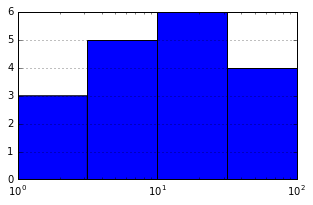

In [176]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xscale('log')

In [177]:
transmat_pop = pd.DataFrame(data=np.zeros((nbins_pop, nbins_pop), dtype=np.float), \
                            columns=np.arange(1, nbins_pop+1), index=np.arange(1, nbins_pop+1))

Count the number of transitions between POI popularity classes.

In [178]:
#np.digitize([101, 0.1], logbins_pop)

In [179]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    assert(len(seq) > 2)
    for pi in range(len(seq)-1):
        p1 = seq[pi]
        p2 = seq[pi+1]
        pop1 = poi_info_t.loc[p1, 'popularity']
        pop2 = poi_info_t.loc[p2, 'popularity']
        pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
        transmat_pop.loc[pc1, pc2] += 1

In [180]:
transmat_pop

,1,2,3,4
1,4,1,0,0
2,2,3,15,8
3,3,13,38,62
4,1,11,52,40


Normalise each row to obtain transition probabilities.

In [181]:
transmat_pop = normalise_transmat(transmat_pop)

In [182]:
transmat_pop

,1,2,3,4
1,0.724138,0.206897,0.034483,0.034483
2,0.071429,0.107143,0.535714,0.285714
3,0.025862,0.112069,0.327586,0.534483
4,0.009615,0.105769,0.500000,0.384615


<a id='sec3.4'></a>

## 3.4 Transition Matrix between POI Average Visit Duration Classes

In [183]:
poi_durations = poi_info_t.loc[poi_train, 'avgDuration(sec)'].unique().tolist()
poi_durations.sort()
np.round(poi_durations, 2)

array([   29.  ,    57.67,    61.  ,   512.  ,   673.5 ,   817.8 ,
        1262.43,  1411.44,  1660.25,  2088.29,  2136.36,  2309.28,
        2475.  ,  3411.71,  3438.64,  3457.39,  3470.51,  4121.9 ,
        4331.  ,  4719.  ,  5248.15,  5315.93,  6772.2 ,  9911.5 ])

Discretize POI average visit duration with uniform log-scale bins (#bins $\le 5$).

In [184]:
exponent_duration = np.log10(max(poi_durations))
exponent_duration

3.9961393853052534

In [189]:
nbins_duration = 5
logbins_duration = np.logspace(0, np.ceil(exponent_duration), nbins_duration+1)
logbins_duration

array([  1.00000000e+00,   6.30957344e+00,   3.98107171e+01,
         2.51188643e+02,   1.58489319e+03,   1.00000000e+04])

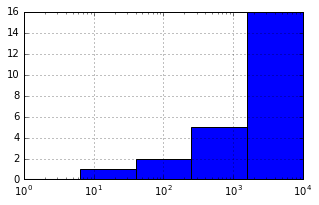

In [190]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xscale('log')

In [191]:
transmat_duration = pd.DataFrame(data=np.zeros((nbins_duration, nbins_duration), dtype=np.float), \
                                 columns=np.arange(1, nbins_duration+1), index=np.arange(1, nbins_duration+1))

Count the number of transitions between POI average visit duration classes.

In [192]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    assert(len(seq) > 2)
    for pi in range(len(seq)-1):
        p1 = seq[pi]
        p2 = seq[pi+1]
        d1 = poi_info_t.loc[p1, 'avgDuration(sec)']
        d2 = poi_info_t.loc[p2, 'avgDuration(sec)']
        dc1, dc2 = np.digitize([d1, d2], logbins_duration)
        transmat_duration.loc[dc1, dc2] += 1

In [193]:
transmat_duration

,1,2,3,4,5
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,1,0,2,20
5,0,0,4,23,203


Normalise each row to obtain transition probabilities.

In [194]:
transmat_duration = normalise_transmat(transmat_duration)

In [195]:
transmat_duration

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.200000,0.200000,0.200000,0.200000,0.200000
3,0.200000,0.200000,0.200000,0.200000,0.200000
4,0.008333,0.050000,0.008333,0.091667,0.841667
5,0.003419,0.003419,0.020513,0.101709,0.870940


<a id='sec3.5'></a>

## 3.5 Transition Matrix between POI Neighborhood Classes

Compute POI neighborhoods, i.e., clustering POI (lat, lon) in training set using k-means, #clusters $\le 5$.

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [230]:
#from sklearn.cluster import KMeans
X = poi_all.loc[poi_train, ['poiLon', 'poiLat']]
nclusters = 5

In [231]:
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [232]:
clusters = kmeans.predict(X)
clusters

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 2, 0, 0, 0, 1, 1, 4,
       4], dtype=int32)

In [240]:
poi_clusters = pd.DataFrame(data=clusters, index=poi_train)
poi_clusters.index.name = 'poiID'
poi_clusters.rename(columns={0:'clusterID'}, inplace=True)
#poi_clusters

In [229]:
diff = poi_all.loc[poi_train, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train, ['poiLon', 'poiLat']].min()
diff['poiLon'] / diff['poiLat']

1.5227639511428037

A $3:2$ figure should be fine.

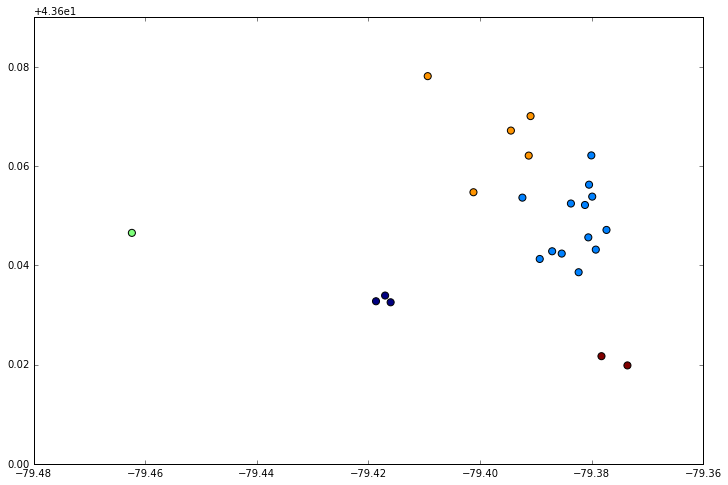

In [233]:
plt.figure(figsize=[12, 8])
plt.scatter(poi_all.loc[poi_train, 'poiLon'], poi_all.loc[poi_train, 'poiLat'], c=clusters, s=50)

In [242]:
transmat_neighbor = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                 columns=np.arange(nclusters), index=np.arange(nclusters))

Count the number of transitions between POIs in different clusters.

In [243]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    assert(len(seq) > 2)
    for pi in range(len(seq)-1):
        p1 = seq[pi]
        p2 = seq[pi+1]
        c1 = poi_clusters.loc[p1, 'clusterID']
        c2 = poi_clusters.loc[p2, 'clusterID']
        transmat_neighbor.loc[c1, c2] += 1

In [244]:
transmat_neighbor

,0,1,2,3,4
0,4,0,0,0,0
1,1,210,0,16,2
2,0,0,0,1,0
3,0,14,0,5,0
4,0,0,0,0,0


Normalise each row to obtain transition probabilities.

In [245]:
transmat_neighbor = normalise_transmat(transmat_neighbor)

In [246]:
transmat_neighbor

,0,1,2,3,4
0,0.600000,0.100000,0.100000,0.100000,0.100000
1,0.005217,0.913913,0.000870,0.070435,0.009565
2,0.100000,0.100000,0.100000,0.600000,0.100000
3,0.041667,0.625000,0.041667,0.250000,0.041667
4,0.200000,0.200000,0.200000,0.200000,0.200000


<a id='sec3.6'></a>

## 3.6 Transition Matrix between POI Features

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

In [257]:
#from scipy.linalg import kron
transmat_value = transmat_cat.values
for transmat in [transmat_pop, transmat_duration, transmat_neighbor]:
    transmat_value = kron(transmat_value, transmat.values)

Index of Kronecker product.

In [258]:
transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_duration, transmat_neighbor))

In [263]:
transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
transmat_feature.index.name = '(poiTheme, popularity, avgDuration, clusterID)'
#transmat_feature.head()

In [264]:
print(transmat_cat.shape)
print(transmat_pop.shape)
print(transmat_duration.shape)
print(transmat_neighbor.shape)
print(transmat_feature.shape)

(6, 6)
(4, 4)
(5, 5)
(5, 5)
(600, 600)


The result of [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) should be normalised to obtain transition probabilities.

Normalise and compute log probability.

In [265]:
logtransmat_feature = np.log(transmat_feature)

In [266]:
#from scipy.misc import logsumexp
for row in range(logtransmat_feature.shape[0]):
    logtransmat_feature.iloc[row] -= logsumexp(logtransmat_feature.iloc[row])

In [268]:
logtransmat_feature.head()

,"(Amusement, 1, 1, 0)","(Amusement, 1, 1, 1)","(Amusement, 1, 1, 2)","(Amusement, 1, 1, 3)","(Amusement, 1, 1, 4)","(Amusement, 1, 2, 0)","(Amusement, 1, 2, 1)","(Amusement, 1, 2, 2)","(Amusement, 1, 2, 3)","(Amusement, 1, 2, 4)",...,"(Structure, 4, 4, 0)","(Structure, 4, 4, 1)","(Structure, 4, 4, 2)","(Structure, 4, 4, 3)","(Structure, 4, 4, 4)","(Structure, 4, 5, 0)","(Structure, 4, 5, 1)","(Structure, 4, 5, 2)","(Structure, 4, 5, 3)","(Structure, 4, 5, 4)"
"(poiTheme, popularity, avgDuration, clusterID)",,,,,,,,,,,,,,,,,,,,,
"(Amusement, 1, 1, 0)",-4.968766,-6.760525,-6.760525,-6.760525,-6.760525,-4.968766,-6.760525,-6.760525,-6.760525,-6.760525,...,-8.013288,-9.805047,-9.805047,-9.805047,-9.805047,-8.013288,-9.805047,-9.805047,-9.805047,-9.805047
"(Amusement, 1, 1, 1)",-9.713698,-4.547960,-11.505457,-7.111008,-9.107562,-9.713698,-4.547960,-11.505457,-7.111008,-9.107562,...,-12.758220,-7.592482,-14.549980,-10.155530,-12.152084,-12.758220,-7.592482,-14.549980,-10.155530,-12.152084
"(Amusement, 1, 1, 2)",-6.760525,-6.760525,-6.760525,-4.968766,-6.760525,-6.760525,-6.760525,-6.760525,-4.968766,-6.760525,...,-9.805047,-9.805047,-9.805047,-8.013288,-9.805047,-9.805047,-9.805047,-9.805047,-8.013288,-9.805047
"(Amusement, 1, 1, 3)",-7.635994,-4.927944,-7.635994,-5.844234,-7.635994,-7.635994,-4.927944,-7.635994,-5.844234,-7.635994,...,-10.680516,-7.972466,-10.680516,-8.888757,-10.680516,-10.680516,-7.972466,-10.680516,-8.888757,-10.680516
"(Amusement, 1, 1, 4)",-6.067378,-6.067378,-6.067378,-6.067378,-6.067378,-6.067378,-6.067378,-6.067378,-6.067378,-6.067378,...,-9.111900,-9.111900,-9.111900,-9.111900,-9.111900,-9.111900,-9.111900,-9.111900,-9.111900,-9.111900


<a id='sec4'></a>

# 4. Combine Ranking with Factorised Markov Chain to Recommend

### Combine

NOTE:
- Ranking is over POIs (in POI space)
- Transition probabilities of Markov Chain of POI features (in POI feature space)

Two approaches:
- recommend trajectory in POI space: 
  - transform transition matrix of feature vector into transition matrix of POIs,
  - recommend a sequence of POIs.
- recommend trajectory in POI feature space: 
  - transform ranking probability of POIs into ranking probability of POI features,
  - recommend a sequence of features, 
  - transform the squence of features into a sequence of POIs.

### Recommendation

Two methods for recommendation:
- find a simple path with maximum objective in a digraph. (by negating log probabilities, it can be reduced to a finding shortest path will $k$-edges, which is probably NP-hard as it is the same as TSP when $L=|P|$, dynamic programming can be used for non-simple path.)
- make greedy choice (of POI or POI feature vector) step-by-step

<a id='sec5'></a>

# 5. Evaluation

Evaluation metrics without considering visiting order.

In [ ]:
def calc_F1score(seq_act, seq_rec)#, includeStartEnd=True):
    assert(len(seq_act) > 2)
    assert(len(seq_rec) > 2)

    act_set = set(seq_act)
    rec_set = set(seq_rec)
    intersect = act_set & rec_set
    
    recall    = len(intersect) / len(act_set) #if includeStartEnd else (len(intersect)-2) / (len(act_set)-2)
    precision = len(intersect) / len(rec_set) #if includeStartEnd else (len(intersect)-2) / (len(rec_set)-2)
    #F1score   = 0 if abs(precision + recall) < 1e-6 else 2. * precision * recall / (precision + recall)
    F1score   = 2. * precision * recall / (precision + recall)
  
    return F1score

In [ ]:
from scipy.misc import comb
from math import factorial
def rand_guess(npoi, length):
    assert(length <= npoi)
    if length == npoi: return 1
    N = npoi - 2
    m = length - 2 # number of correct POIs
    k = m
    expected_F1 = 0
    while k >= 0:
        F1 = (k + 2) / length
        prob = comb(m, k) * comb(N-m, m-k) / comb(N, m)
        expected_F1 += prob * F1
        k -= 1
    return expected_F1

Sanity check.

In [ ]:
rand_guess(20, 5)